In [43]:
import pandas as pd
data_path = '/Users/charansaisadla/Desktop/ub classes/SEM2/NLP/data project/'
df=pd.read_csv(data_path+"input.csv")
df

,Unnamed: 0,text,class
0,0,news latest headlines on cnn business n tldr t...,0
1,1,news china wants to take a victory lap over it...,0
2,2,news coronavirus disinformation creates challe...,0
3,3,news china coronavirus eating wild animals mad...,0
4,4,news chinas economy could shrink for the first...,0
...,...,...,...
11721,11721,how much of your body is your own your entire ...,10
11722,11722,how do you keep a space station clean keeping ...,10
11723,11723,the city where you pay a years rent up front t...,10
11724,11724,the bbc news app gives you the best of bbc new...,10


In [8]:
df.head()

,Unnamed: 0,text,class
0,0,news latest headlines on cnn business n tldr t...,0
1,1,news china wants to take a victory lap over it...,0
2,2,news coronavirus disinformation creates challe...,0
3,3,news china coronavirus eating wild animals mad...,0
4,4,news chinas economy could shrink for the first...,0


In [9]:
# filter rows that have class 8
df_class8 = df[df['class'] == 7]

# filter rows that have class 10
df_class10 = df[df['class'] == 10]

# merge the two dataframes
df_filtered = pd.concat([df_class8, df_class10])
df_filtered




,Unnamed: 0,text,class
7462,7462,the great shutdown of 2020 how newsrooms and m...,7
7463,7463,hong kong cnn chinas communist party wants mor...,7
7464,7464,hong kong cnn the word rumor has taken on a di...,7
7465,7465,hong kong cnn a strict ban on the consumption ...,7
7466,7466,hong kong cnn business the novel coronavirus o...,7
...,...,...,...
11721,11721,how much of your body is your own your entire ...,10
11722,11722,how do you keep a space station clean keeping ...,10
11723,11723,the city where you pay a years rent up front t...,10
11724,11724,the bbc news app gives you the best of bbc new...,10


array([9])

In [10]:
x=df_filtered.reset_index(drop=True)
df=x
df['class'] = df['class'].apply(lambda x: 1 if x==7 else 0)
df



,Unnamed: 0,text,class
0,7462,the great shutdown of 2020 how newsrooms and m...,1
1,7463,hong kong cnn chinas communist party wants mor...,1
2,7464,hong kong cnn the word rumor has taken on a di...,1
3,7465,hong kong cnn a strict ban on the consumption ...,1
4,7466,hong kong cnn business the novel coronavirus o...,1
...,...,...,...
2127,11721,how much of your body is your own your entire ...,0
2128,11722,how do you keep a space station clean keeping ...,0
2129,11723,the city where you pay a years rent up front t...,0
2130,11724,the bbc news app gives you the best of bbc new...,0


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [12]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
import torch

def tokenize_and_encode(text, tokenizer, max_length):
    input_ids = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='pt')
    return input_ids['input_ids'], input_ids['attention_mask']

In [14]:
def get_dataloader(df, tokenizer, max_length, batch_size, shuffle=True):
    texts = df['text'].values
    labels = df['class'].values
    
    input_ids = []
    attention_masks = []
    
    for text in texts:
        input_id, attention_mask = tokenize_and_encode(text, tokenizer, max_length)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataloader


In [15]:
def train_model(model, train_dataloader, optimizer, device):
    model.train()
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
    
    return model


In [18]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, val_dataloader, device):
    model.eval()
    val_loss, val_accuracy = 0, 0
    n_val_steps = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
            val_accuracy += (preds == labels).float().mean().item()
            n_val_steps += 1

    val_loss /= n_val_steps
    val_accuracy /= n_val_steps

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return val_loss, val_accuracy, precision, recall, f1


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch 1 Val Loss: 0.330, Val Accuracy: 0.871, Val Precision: 0.890, Val Recall: 0.871, Val F1: 0.869


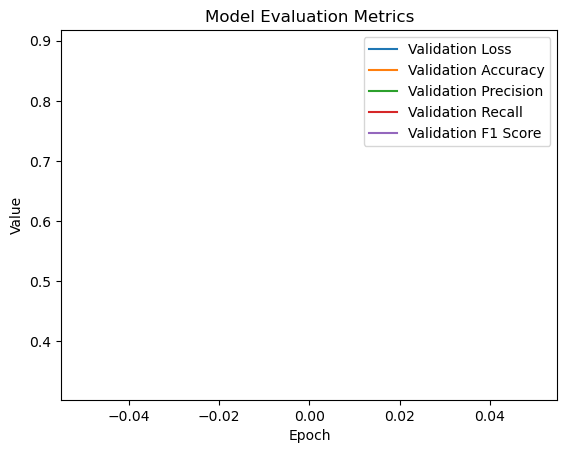

Epoch 2 Val Loss: 0.334, Val Accuracy: 0.875, Val Precision: 0.895, Val Recall: 0.876, Val F1: 0.874


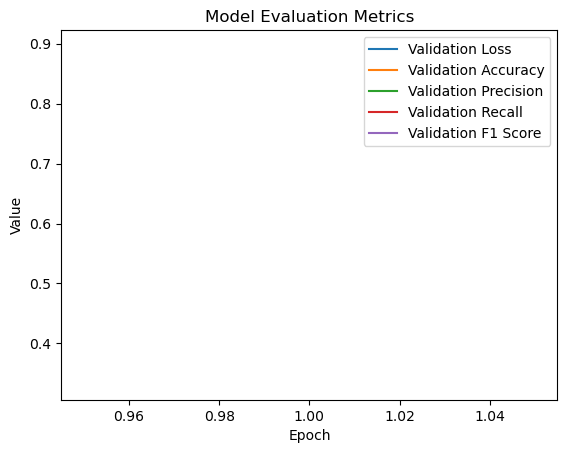

Epoch 3 Val Loss: 0.184, Val Accuracy: 0.949, Val Precision: 0.950, Val Recall: 0.948, Val F1: 0.948


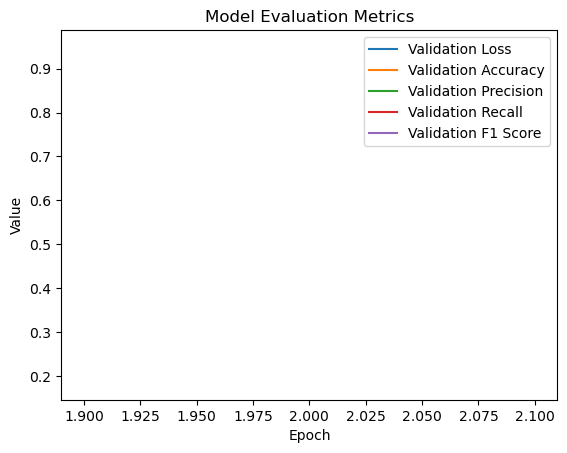

Epoch 4 Val Loss: 0.272, Val Accuracy: 0.936, Val Precision: 0.940, Val Recall: 0.937, Val F1: 0.937


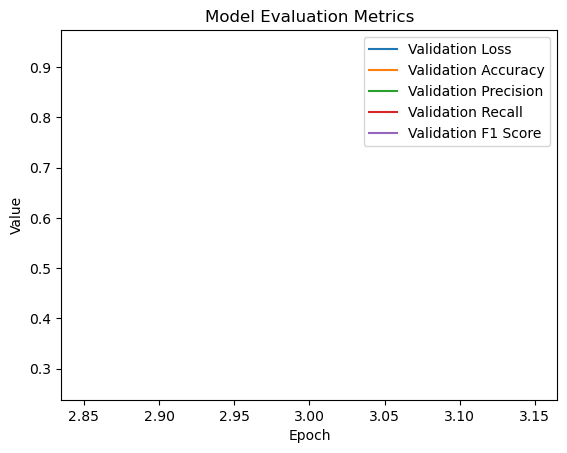

Epoch 5 Val Loss: 0.193, Val Accuracy: 0.951, Val Precision: 0.951, Val Recall: 0.951, Val F1: 0.951


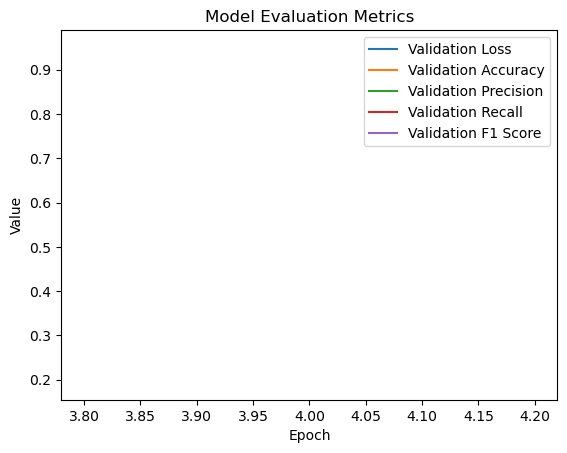

In [19]:
import matplotlib.pyplot as plt
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

device = torch.device("mps")
model = BertForSequenceClassification.from_pretrained("bert-base-cased").to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_dataloader = get_dataloader(train_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_dataloader = get_dataloader(test_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

for epoch in range(NUM_EPOCHS):
    train_model(model, train_dataloader, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_dataloader, device)
    print(f"Epoch {epoch + 1} Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}, Val Precision: {val_precision:.3f}, Val Recall: {val_recall:.3f}, Val F1: {val_f1:.3f}")
    plt.plot(epoch, val_loss, label='Validation Loss')
# Plot the validation accuracy
    plt.plot(epoch, val_accuracy, label='Validation Accuracy')
    # Plot the validation precision
    plt.plot(epoch, val_precision, label='Validation Precision')
    # Plot the validation recall
    plt.plot(epoch, val_recall, label='Validation Recall')
    # Plot the validation F1 score
    plt.plot(epoch, val_f1, label='Validation F1 Score')

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Model Evaluation Metrics')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()




OSError: [Errno 30] Read-only file system: 'table.png'

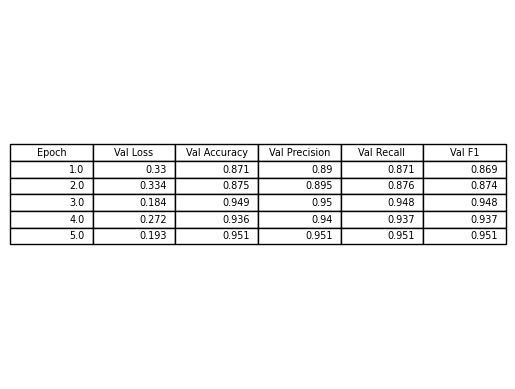

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the validation metrics for each epoch
epochs = [1, 2, 3, 4, 5]
val_loss = [0.330, 0.334, 0.184, 0.272, 0.193]
val_accuracy = [0.871, 0.875, 0.949, 0.936, 0.951]
val_precision = [0.890, 0.895, 0.950, 0.940, 0.951]
val_recall = [0.871, 0.876, 0.948, 0.937, 0.951]
val_f1 = [0.869, 0.874, 0.948, 0.937, 0.951]

# Combine the validation metrics into a pandas DataFrame
df = pd.DataFrame({
    'Epoch': epochs,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy,
    'Val Precision': val_precision,
    'Val Recall': val_recall,
    'Val F1': val_f1
})

# Create the table using matplotlib
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Save the table as an image
plt.savefig('table.png')


In [37]:
import pandas as pd

data = {'Epoch': [1, 2, 3, 4, 5],
        'Val Loss': [0.330, 0.334, 0.184, 0.272, 0.193],
        'Val Accuracy': [0.871, 0.875, 0.949, 0.936, 0.951],
        'Val Precision': [0.890, 0.895, 0.950, 0.940, 0.951],
        'Val Recall': [0.871, 0.876, 0.948, 0.937, 0.951],
        'Val F1': [0.869, 0.874, 0.948, 0.937, 0.951]}

df = pd.DataFrame(data)

styled_table = df.style.set_table_styles(
[{'selector': 'th', 
  'props': [('background-color', 'white'), 
           ('color', 'black'), 
           ('font-weight', 'bold'), 
           ('border', '2px solid black'), 
           ('padding', '2px')]},
 {'selector': 'td', 
  'props': [('border', '2px solid black'), 
            ('padding', '2px')]}])

styled_table


,Epoch,Val Loss,Val Accuracy,Val Precision,Val Recall,Val F1
0,1,0.330000,0.871000,0.890000,0.871000,0.869000
1,2,0.334000,0.875000,0.895000,0.876000,0.874000
2,3,0.184000,0.949000,0.950000,0.948000,0.948000
3,4,0.272000,0.936000,0.940000,0.937000,0.937000
4,5,0.193000,0.951000,0.951000,0.951000,0.951000


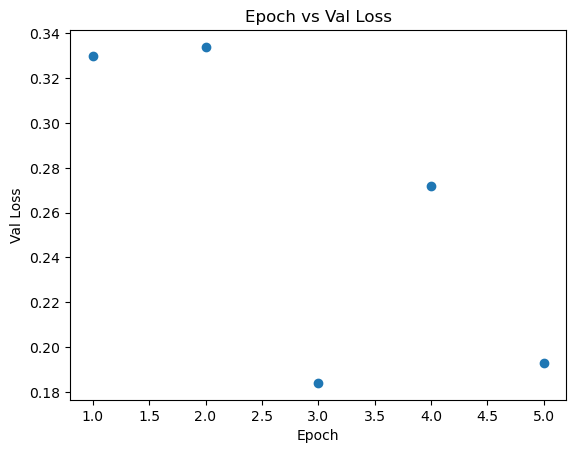

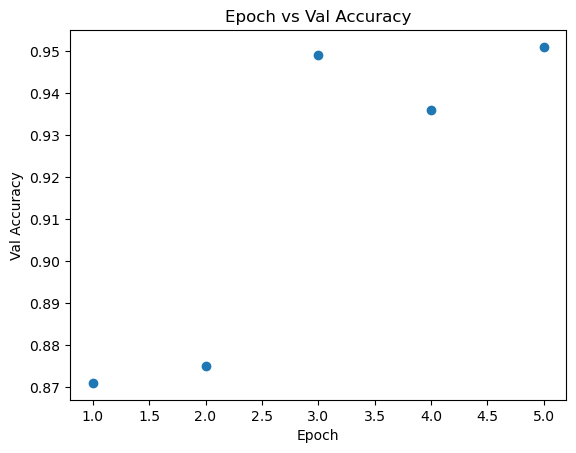

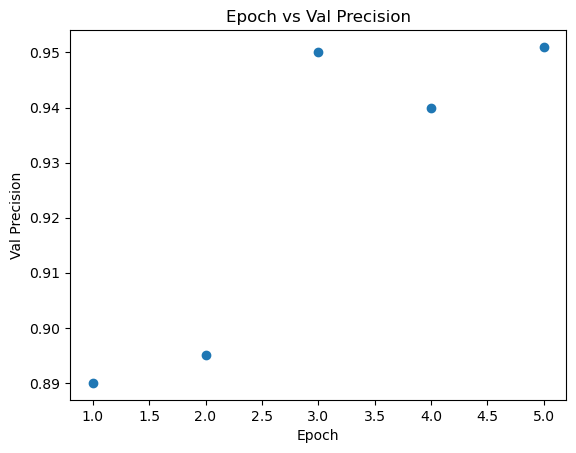

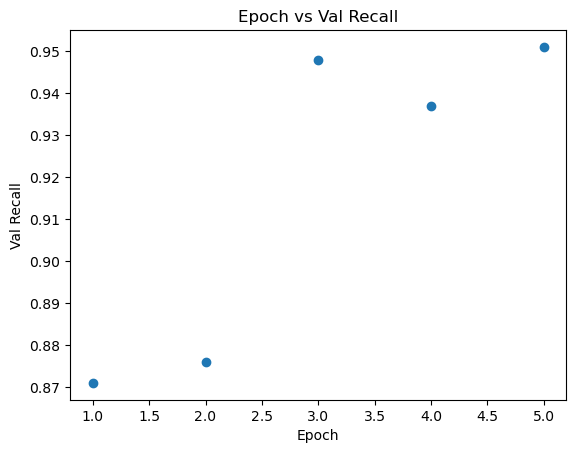

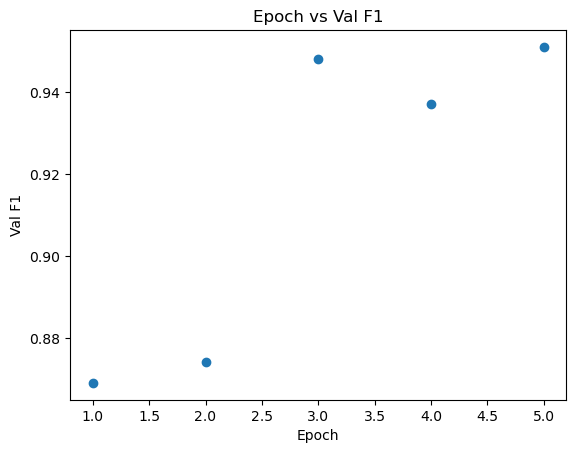

In [38]:
data = {'Epoch': [1, 2, 3, 4, 5],
        'Val Loss': [0.330, 0.334, 0.184, 0.272, 0.193],
        'Val Accuracy': [0.871, 0.875, 0.949, 0.936, 0.951],
        'Val Precision': [0.890, 0.895, 0.950, 0.940, 0.951],
        'Val Recall': [0.871, 0.876, 0.948, 0.937, 0.951],
        'Val F1': [0.869, 0.874, 0.948, 0.937, 0.951]}

df = pd.DataFrame(data)

# Scatter plot of Epoch vs Val Loss
plt.scatter(df['Epoch'], df['Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.title('Epoch vs Val Loss')
plt.show()

# Scatter plot of Epoch vs Val Accuracy
plt.scatter(df['Epoch'], df['Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.title('Epoch vs Val Accuracy')
plt.show()

# Scatter plot of Epoch vs Val Precision
plt.scatter(df['Epoch'], df['Val Precision'])
plt.xlabel('Epoch')
plt.ylabel('Val Precision')
plt.title('Epoch vs Val Precision')
plt.show()

# Scatter plot of Epoch vs Val Recall
plt.scatter(df['Epoch'], df['Val Recall'])
plt.xlabel('Epoch')
plt.ylabel('Val Recall')
plt.title('Epoch vs Val Recall')
plt.show()

# Scatter plot of Epoch vs Val F1
plt.scatter(df['Epoch'], df['Val F1'])
plt.xlabel('Epoch')
plt.ylabel('Val F1')
plt.title('Epoch vs Val F1')
plt.show()



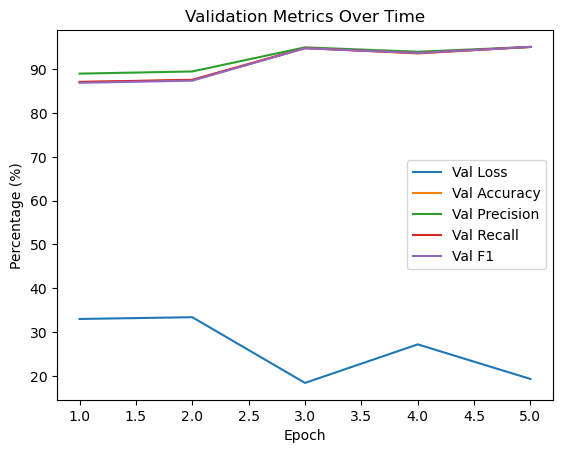

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

data = {'Epoch': [1, 2, 3, 4, 5],
        'Val Loss': [33.0, 33.4, 18.4, 27.2, 19.3],
        'Val Accuracy': [87.1, 87.5, 94.9, 93.6, 95.1],
        'Val Precision': [89.0, 89.5, 95.0, 94.0, 95.1],
        'Val Recall': [87.1, 87.6, 94.8, 93.7, 95.1],
        'Val F1': [86.9, 87.4, 94.8, 93.7, 95.1]}

df = pd.DataFrame(data)
df = df.set_index('Epoch')  # Set Epoch as the index

plt.plot(df)
plt.legend(df.columns)
plt.title('Validation Metrics Over Time')
plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.show()



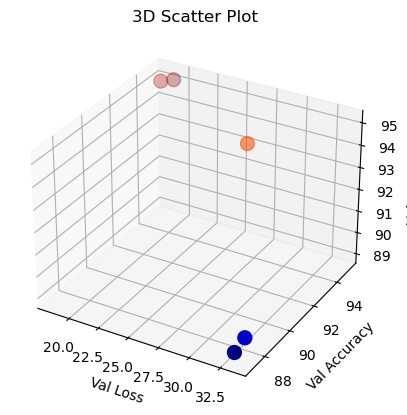

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = {'Epoch': [1, 2, 3, 4, 5],
        'Val Loss': [33.0, 33.4, 18.4, 27.2, 19.3],
        'Val Accuracy': [87.1, 87.5, 94.9, 93.6, 95.1],
        'Val Precision': [89.0, 89.5, 95.0, 94.0, 95.1],
        'Val Recall': [87.1, 87.6, 94.8, 93.7, 95.1],
        'Val F1': [86.9, 87.4, 94.8, 93.7, 95.1]}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = data['Val Loss']
ys = data['Val Accuracy']
zs = data['Val Precision']
ws = data['Val Recall']
vs = data['Val F1']

ax.scatter(xs, ys, zs, c=ws, cmap='jet', s=100)
ax.set_xlabel('Val Loss')
ax.set_ylabel('Val Accuracy')
ax.set_zlabel('Val Precision')
plt.title('3D Scatter Plot')
plt.show()


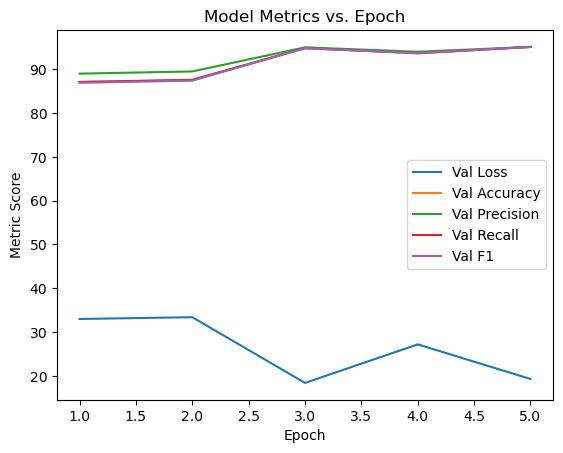

In [42]:
import matplotlib.pyplot as plt

data = {'Epoch': [1, 2, 3, 4, 5],
        'Val Loss': [33.0, 33.4, 18.4, 27.2, 19.3],
        'Val Accuracy': [87.1, 87.5, 94.9, 93.6, 95.1],
        'Val Precision': [89.0, 89.5, 95.0, 94.0, 95.1],
        'Val Recall': [87.1, 87.6, 94.8, 93.7, 95.1],
        'Val F1': [86.9, 87.4, 94.8, 93.7, 95.1]}

plt.plot(data['Epoch'], data['Val Loss'], label='Val Loss')
plt.plot(data['Epoch'], data['Val Accuracy'], label='Val Accuracy')
plt.plot(data['Epoch'], data['Val Precision'], label='Val Precision')
plt.plot(data['Epoch'], data['Val Recall'], label='Val Recall')
plt.plot(data['Epoch'], data['Val F1'], label='Val F1')

plt.title('Model Metrics vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metric Score')
plt.legend()
plt.show()


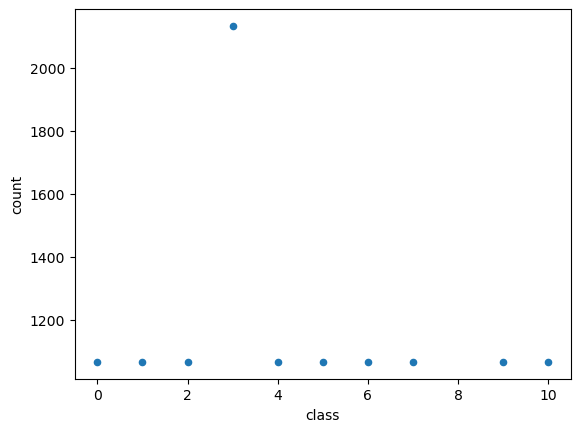

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame with a "class" colum

# count the frequency of each class
class_counts = df["class"].value_counts()

# convert the Series to a DataFrame
class_counts_df = class_counts.to_frame()

# reset the index to turn the index into a column
class_counts_df = class_counts_df.reset_index()

# rename the columns to "class" and "count"
class_counts_df.columns = ["class", "count"]

# create a scatter plot with the "class" on the x-axis and the "count" on the y-axis
class_counts_df.plot.scatter(x="class", y="count")

# display the plot
plt.show()


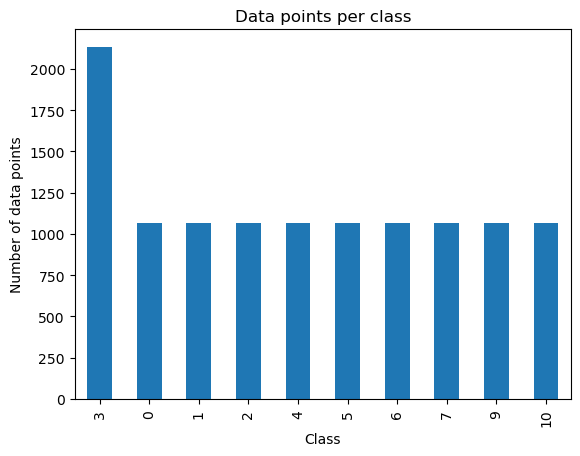

In [45]:
class_counts = df["class"].value_counts()

# create a bar plot of the class counts
class_counts.plot(kind="bar")

# set axis labels and title
plt.xlabel("Class")
plt.ylabel("Number of data points")
plt.title("Data points per class")

# display the plot
plt.show()